# Polymarket Trading Analysis

This notebook analyzes trading activity to identify the most profitable and least profitable markets.

## Configuration

In [64]:
import os
import sys
from datetime import datetime, timedelta
import pandas as pd
import requests
from typing import List, Dict
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
load_dotenv()

# Configure matplotlib for better-looking plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [65]:
# ===== CONFIGURATION PARAMETERS =====

# Wallet address to analyze
WALLET_ADDRESS = os.getenv('BROWSER_ADDRESS')

# Timeframe configuration (Unix timestamps)
# Default: Last 30 days
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=1)

# Convert to Unix timestamps (seconds)
START_TIMESTAMP = int(START_DATE.timestamp())
END_TIMESTAMP = int(END_DATE.timestamp())

# API Configuration
API_BASE_URL = 'https://data-api.polymarket.com'
REQUEST_LIMIT = 500  # Max results per request

print(f"Analyzing wallet: {WALLET_ADDRESS}")
print(f"Date range: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"Timestamp range: {START_TIMESTAMP} to {END_TIMESTAMP}")

Analyzing wallet: 0xC3dA2b26f845d799B9d456828753f5a3af57d974
Date range: 2025-10-26 to 2025-10-27
Timestamp range: 1761514991 to 1761601391


## Data Collection

In [66]:
def fetch_trading_activity(wallet_address: str, start: int, end: int) -> List[Dict]:
    """
    Fetch all trading activity for a wallet within the specified timeframe.
    
    Args:
        wallet_address: Ethereum wallet address
        start: Start timestamp (Unix seconds)
        end: End timestamp (Unix seconds)
    
    Returns:
        List of trading activity records
    """
    all_activities = []
    offset = 0
    
    while True:
        params = {
            'user': wallet_address,
            'type': 'TRADE',
            'limit': REQUEST_LIMIT,
            'offset': offset,
            'start': start,
            'end': end,
            'sortBy': 'TIMESTAMP',
            'sortDirection': 'DESC'
        }
        
        try:
            response = requests.get(f'{API_BASE_URL}/activity', params=params)
            response.raise_for_status()
            
            activities = response.json()
            
            if not activities or len(activities) == 0:
                break
            
            all_activities.extend(activities)
            
            print(f"Fetched {len(activities)} activities (offset: {offset}, total: {len(all_activities)})")
            
            # Check if we've reached the end
            if len(activities) < REQUEST_LIMIT:
                break
            
            offset += REQUEST_LIMIT
            
        except requests.exceptions.RequestException as e:
            print(f"Error fetching data: {e}")
            break
    
    print(f"\nTotal activities fetched: {len(all_activities)}")
    return all_activities

In [67]:
# Fetch all trading activity
activities = fetch_trading_activity(WALLET_ADDRESS, START_TIMESTAMP, END_TIMESTAMP)

if not activities:
    print("⚠️ No trading activity found in the specified timeframe")
else:
    print(f"✅ Successfully fetched {len(activities)} trades")

Fetched 47 activities (offset: 0, total: 47)

Total activities fetched: 47
✅ Successfully fetched 47 trades


## Data Processing

In [68]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(activities)

# Display basic information
print(f"Total trades: {len(df)}")
print(f"\nColumns available: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Total trades: 47

Columns available: ['proxyWallet', 'timestamp', 'conditionId', 'type', 'size', 'usdcSize', 'transactionHash', 'price', 'asset', 'side', 'outcomeIndex', 'title', 'slug', 'icon', 'eventSlug', 'outcome', 'name', 'pseudonym', 'bio', 'profileImage', 'profileImageOptimized']

First few rows:


,proxyWallet,timestamp,conditionId,type,size,usdcSize,transactionHash,price,asset,side,...,title,slug,icon,eventSlug,outcome,name,pseudonym,bio,profileImage,profileImageOptimized
0,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761599565,0x8b7ffa2267c76412d7eff4b0382e8ad411ec128ad6d0...,TRADE,19.70,4.6886,0xcbf3c0a88cb25411e7afed05260e4d08ba55a43c9c91...,0.238,8070496507501109885164914547261234643998747253...,BUY,...,Will Exxon Mobil (XOM) beat quarterly earnings?,xom-quarterly-earnings-nongaap-eps-2025-10-31-...,https://polymarket-upload.s3.us-east-2.amazona...,xom-quarterly-earnings-nongaap-eps-2025-10-31-...,No,alcaudi,Meaty-Prevalence,,,
1,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761594999,0xa4bdb50db073da1c1ea7bbebe1a1fda29ada113f9e86...,TRADE,383.98,264.9462,0x29b8309d360f5ecb85ac1fcee7ae1e3b5ad8cc84bfb4...,0.690,9832925089363836700402770027825763759869433994...,SELL,...,Will the U.S. tariff rate on China be between ...,will-the-us-tariff-rate-on-china-be-between-25...,https://polymarket-upload.s3.us-east-2.amazona...,us-tariff-rate-on-china-on-november-12-2025,Yes,alcaudi,Meaty-Prevalence,,,
2,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761594963,0xa4bdb50db073da1c1ea7bbebe1a1fda29ada113f9e86...,TRADE,200.10,140.0700,0x54fc621a4c03ca33cbacce3a1533f1ca8c8652b82357...,0.700,9832925089363836700402770027825763759869433994...,SELL,...,Will the U.S. tariff rate on China be between ...,will-the-us-tariff-rate-on-china-be-between-25...,https://polymarket-upload.s3.us-east-2.amazona...,us-tariff-rate-on-china-on-november-12-2025,Yes,alcaudi,Meaty-Prevalence,,,
3,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761592709,0xfe9963374c6ef0506321b115287a17e113466b19d626...,TRADE,50.00,42.5000,0x72b2dffb4bb80184ec669ce1238e132b4c7d2af11d09...,0.850,3804701327446425885011708113225631959729417131...,SELL,...,Will D66 be part of the next Government of the...,will-d66-be-part-of-the-next-government-of-the...,https://polymarket-upload.s3.us-east-2.amazona...,which-parties-will-be-part-of-next-government-...,Yes,alcaudi,Meaty-Prevalence,,,
4,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761591875,0xa4bdb50db073da1c1ea7bbebe1a1fda29ada113f9e86...,TRADE,195.46,142.6858,0x46be7b68d57145f5ce004ca62da384b86bf0e029ae73...,0.730,9832925089363836700402770027825763759869433994...,BUY,...,Will the U.S. tariff rate on China be between ...,will-the-us-tariff-rate-on-china-be-between-25...,https://polymarket-upload.s3.us-east-2.amazona...,us-tariff-rate-on-china-on-november-12-2025,Yes,alcaudi,Meaty-Prevalence,,,


In [69]:
# Convert timestamp to datetime
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

# Convert numeric fields
df['usdcSize'] = pd.to_numeric(df['usdcSize'])
df['size'] = pd.to_numeric(df['size'])
df['price'] = pd.to_numeric(df['price'])

# Calculate cash flow: negative for buys, positive for sells
df['cash_flow'] = df.apply(
    lambda row: -row['usdcSize'] if row['side'] == 'BUY' else row['usdcSize'],
    axis=1
)

print("Data processing complete!")
print("\nTrade breakdown:")
print(df['side'].value_counts())
print(f"\nTotal cash flow: ${df['cash_flow'].sum():,.2f}")

Data processing complete!

Trade breakdown:
side
SELL    29
BUY     18
Name: count, dtype: int64

Total cash flow: $323.63


## P&L Analysis by Market

In [70]:
# Group by market and calculate total P&L
market_pnl = df.groupby(['asset', 'title', 'outcome']).agg({
    'cash_flow': 'sum',
    'usdcSize': ['sum', 'count'],
    'datetime': ['min', 'max']
}).reset_index()

# Flatten column names
market_pnl.columns = ['asset', 'title', 'outcome', 'pnl', 'total_volume', 'trade_count', 'first_trade', 'last_trade']

# Sort by P&L
market_pnl = market_pnl.sort_values('pnl', ascending=False)

print(f"Total unique markets traded: {len(market_pnl)}")
print(f"\nOverall P&L: ${market_pnl['pnl'].sum():,.2f}")
print(f"Total volume traded: ${market_pnl['total_volume'].sum():,.2f}")
print(f"Total trades: {market_pnl['trade_count'].sum():,.0f}")

Total unique markets traded: 24

Overall P&L: $323.63
Total volume traded: $1,677.16
Total trades: 47


## Top 10 Most Profitable Markets

In [71]:
top_gainers = market_pnl.head(10)

print("🟢 TOP 10 MOST PROFITABLE MARKETS\n")
print("=" * 100)

for idx, row in top_gainers.iterrows():
    print(f"\n{row.name + 1}. {row['title']} - {row['outcome']}")
    print(f"   Asset ID: {row['asset']}")
    print(f"   P&L: ${row['pnl']:,.2f}")
    print(f"   Volume: ${row['total_volume']:,.2f} | Trades: {row['trade_count']:.0f}")
    print(f"   Period: {row['first_trade'].strftime('%Y-%m-%d')} to {row['last_trade'].strftime('%Y-%m-%d')}")

print("\n" + "=" * 100)
print(f"Total profit from top 10: ${top_gainers['pnl'].sum():,.2f}")

🟢 TOP 10 MOST PROFITABLE MARKETS


24. Will the U.S. tariff rate on China be between 25% and 40% on November 12? - Yes
   Asset ID: 98329250893638367004027700278257637598694339949653776645150029544719501267752
   P&L: $120.96
   Volume: $829.34 | Trades: 10
   Period: 2025-10-27 to 2025-10-27

6. Will Trump establish a Gaza “Board of Peace” in 2025? - No
   Asset ID: 32915172045130582917964947903812851358453405101351914444477985913955849289820
   P&L: $113.53
   Volume: $113.53 | Trades: 2
   Period: 2025-10-27 to 2025-10-27

22. Will 'A Minecraft Movie' have the best domestic opening weekend in 2025? - No
   Asset ID: 94827473337838024479942925063652176184042024086267448911008823596517504670332
   P&L: $67.27
   Volume: $67.27 | Trades: 2
   Period: 2025-10-27 to 2025-10-27

4. Will Anthropic not IPO by June 30, 2026? - No
   Asset ID: 115325941598173083223514202069551504506839832374902801149030045097943446509453
   P&L: $45.95
   Volume: $45.95 | Trades: 1
   Period: 2025-10-27 to 20

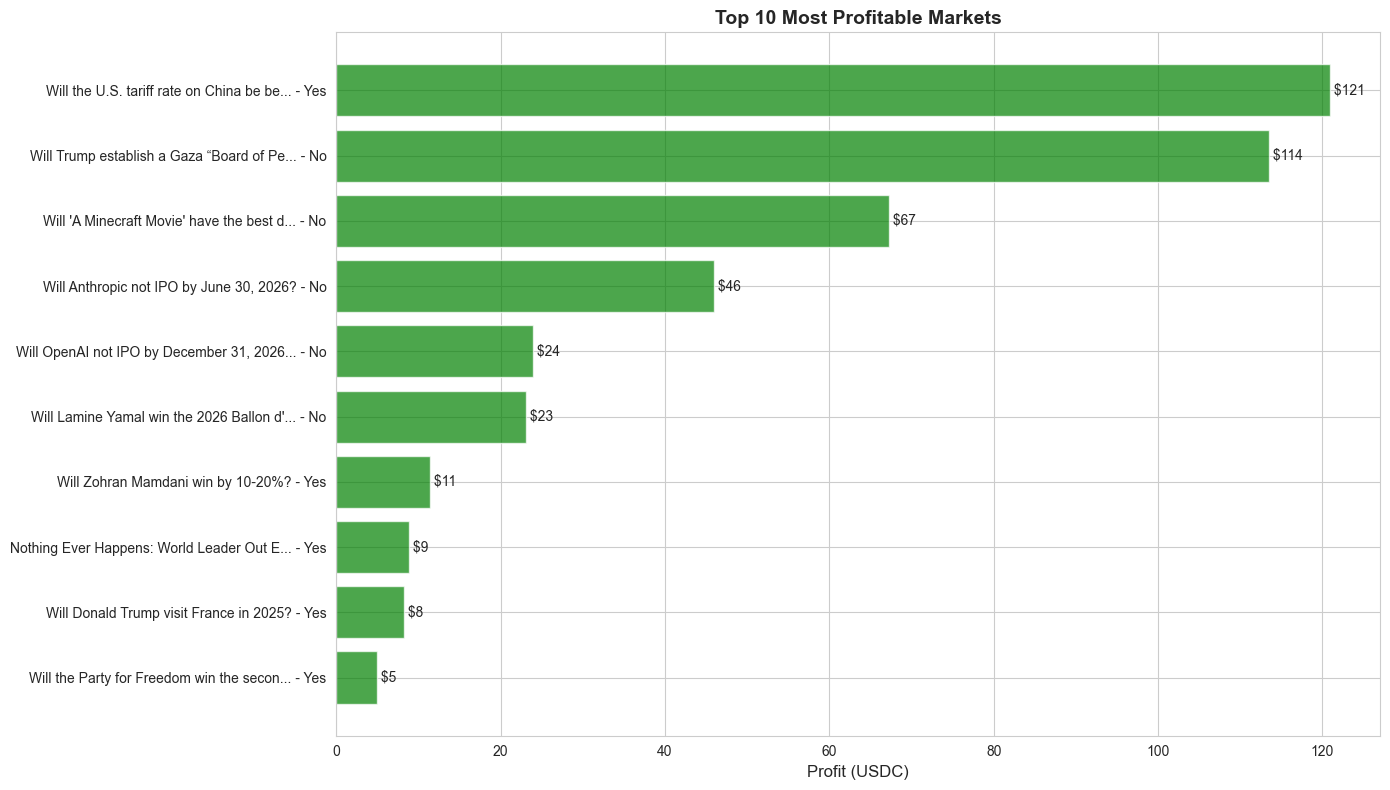

In [72]:
# Visualize top gainers
fig, ax = plt.subplots(figsize=(14, 8))

# Create labels with market name and outcome
labels = [f"{row['title'][:40]}... - {row['outcome']}" if len(row['title']) > 40 
          else f"{row['title']} - {row['outcome']}" 
          for _, row in top_gainers.iterrows()]

y_pos = range(len(labels))

bars = ax.barh(y_pos, top_gainers['pnl'], color='green', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Profit (USDC)', fontsize=12)
ax.set_title('Top 10 Most Profitable Markets', fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Highest profit at top

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_gainers['pnl'])):
    ax.text(val, i, f' ${val:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Top 10 Most Unprofitable Markets

In [73]:
top_losers = market_pnl.tail(10).sort_values('pnl')

print("🔴 TOP 10 MOST UNPROFITABLE MARKETS\n")
print("=" * 100)

for idx, row in top_losers.iterrows():
    print(f"\n{row.name + 1}. {row['title']} - {row['outcome']}")
    print(f"   Asset ID: {row['asset']}")
    print(f"   P&L: ${row['pnl']:,.2f}")
    print(f"   Volume: ${row['total_volume']:,.2f} | Trades: {row['trade_count']:.0f}")
    print(f"   Period: {row['first_trade'].strftime('%Y-%m-%d')} to {row['last_trade'].strftime('%Y-%m-%d')}")

print("\n" + "=" * 100)
print(f"Total loss from bottom 10: ${top_losers['pnl'].sum():,.2f}")

🔴 TOP 10 MOST UNPROFITABLE MARKETS


7. Will the Government shutdown end by November 30? - Yes
   Asset ID: 33863269898549252781275803678269200480782857182444175052616333799704258288948
   P&L: $-84.00
   Volume: $84.00 | Trades: 1
   Period: 2025-10-27 to 2025-10-27

21. Will the Government shutdown end by November 30? - No
   Asset ID: 87619567402357953698530677582070603378003810965807378816593030714809400656142
   P&L: $-22.00
   Volume: $110.00 | Trades: 4
   Period: 2025-10-27 to 2025-10-27

19. Will Exxon Mobil (XOM) beat quarterly earnings? - No
   Asset ID: 80704965075011098851649145472612346439987472535253757475270587766261451418770
   P&L: $-4.69
   Volume: $4.69 | Trades: 1
   Period: 2025-10-27 to 2025-10-27

3. Will NVIDIA be the largest company in the world by market cap on June 30? - Yes
   Asset ID: 114266735877811876021362945683127542532778925409590599016489267644246881997088
   P&L: $-2.46
   Volume: $2.46 | Trades: 1
   Period: 2025-10-27 to 2025-10-27

15. Will one 

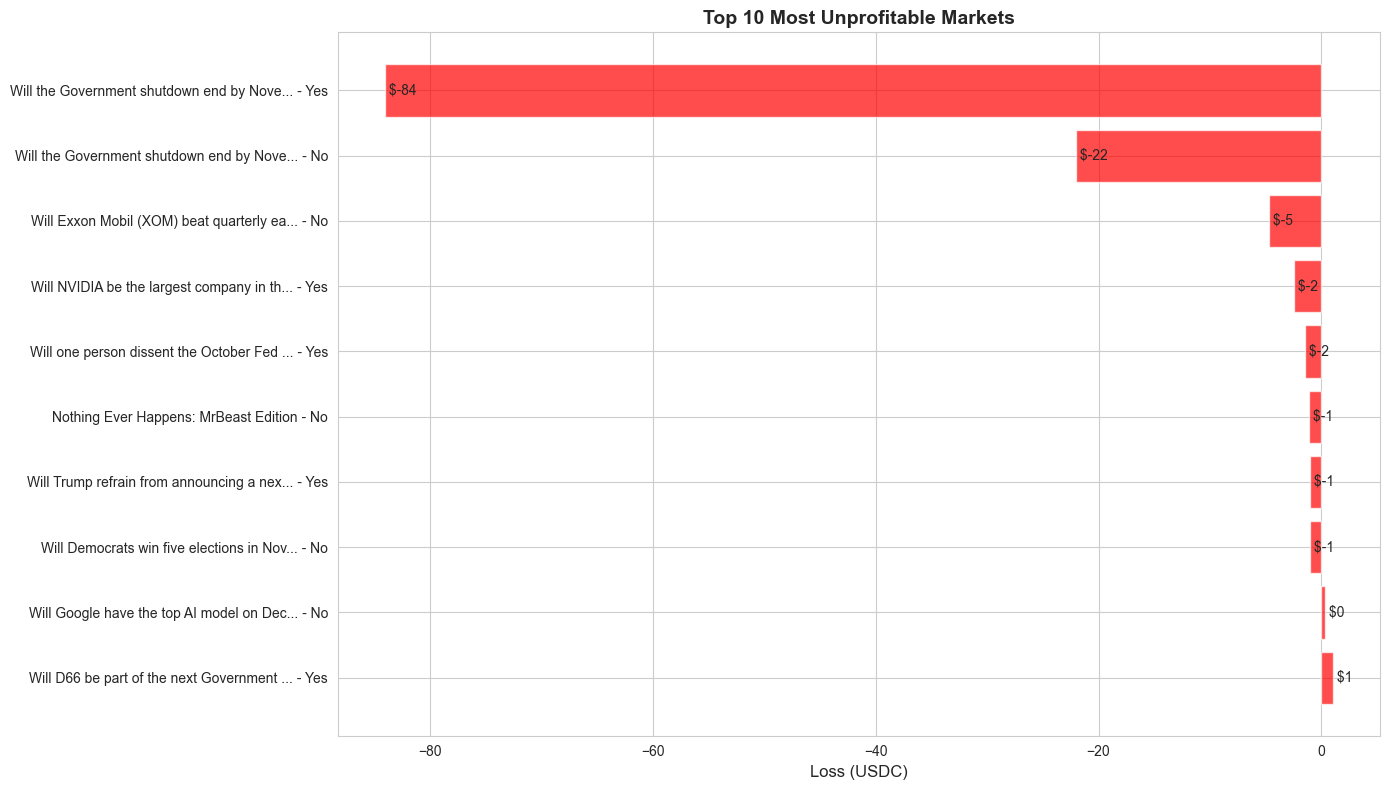

In [74]:
# Visualize top losers
fig, ax = plt.subplots(figsize=(14, 8))

# Create labels with market name and outcome
labels = [f"{row['title'][:40]}... - {row['outcome']}" if len(row['title']) > 40 
          else f"{row['title']} - {row['outcome']}" 
          for _, row in top_losers.iterrows()]

y_pos = range(len(labels))

bars = ax.barh(y_pos, top_losers['pnl'], color='red', alpha=0.7)
ax.set_yticks(y_pos)
ax.set_yticklabels(labels)
ax.set_xlabel('Loss (USDC)', fontsize=12)
ax.set_title('Top 10 Most Unprofitable Markets', fontsize=14, fontweight='bold')
ax.invert_yaxis()  # Highest loss at top

# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, top_losers['pnl'])):
    ax.text(val, i, f' ${val:,.0f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Summary Statistics

In [75]:
# Overall statistics
total_pnl = market_pnl['pnl'].sum()
positive_markets = len(market_pnl[market_pnl['pnl'] > 0])
negative_markets = len(market_pnl[market_pnl['pnl'] < 0])
neutral_markets = len(market_pnl[market_pnl['pnl'] == 0])

total_profit = market_pnl[market_pnl['pnl'] > 0]['pnl'].sum()
total_loss = market_pnl[market_pnl['pnl'] < 0]['pnl'].sum()

print("📊 SUMMARY STATISTICS")
print("=" * 60)
print(f"\nTimeframe: {START_DATE.strftime('%Y-%m-%d')} to {END_DATE.strftime('%Y-%m-%d')}")
print(f"\nNet P&L: ${total_pnl:,.2f}")
print(f"Total Gross Profit: ${total_profit:,.2f}")
print(f"Total Gross Loss: ${total_loss:,.2f}")
print(f"\nProfit Factor: {abs(total_profit / total_loss) if total_loss != 0 else float('inf'):.2f}")
print(f"\nMarkets traded: {len(market_pnl)}")
print(f"  - Profitable: {positive_markets} ({positive_markets/len(market_pnl)*100:.1f}%)")
print(f"  - Unprofitable: {negative_markets} ({negative_markets/len(market_pnl)*100:.1f}%)")
print(f"  - Breakeven: {neutral_markets} ({neutral_markets/len(market_pnl)*100:.1f}%)")
print(f"\nAverage P&L per market: ${market_pnl['pnl'].mean():,.2f}")
print(f"Median P&L per market: ${market_pnl['pnl'].median():,.2f}")
print(f"\nTotal volume: ${market_pnl['total_volume'].sum():,.2f}")
print(f"Total trades: {market_pnl['trade_count'].sum():,.0f}")
print("\n" + "=" * 60)

📊 SUMMARY STATISTICS

Timeframe: 2025-10-26 to 2025-10-27

Net P&L: $323.63
Total Gross Profit: $441.47
Total Gross Loss: $-117.84

Profit Factor: 3.75

Markets traded: 24
  - Profitable: 16 (66.7%)
  - Unprofitable: 8 (33.3%)
  - Breakeven: 0 (0.0%)

Average P&L per market: $13.48
Median P&L per market: $2.95

Total volume: $1,677.16
Total trades: 47



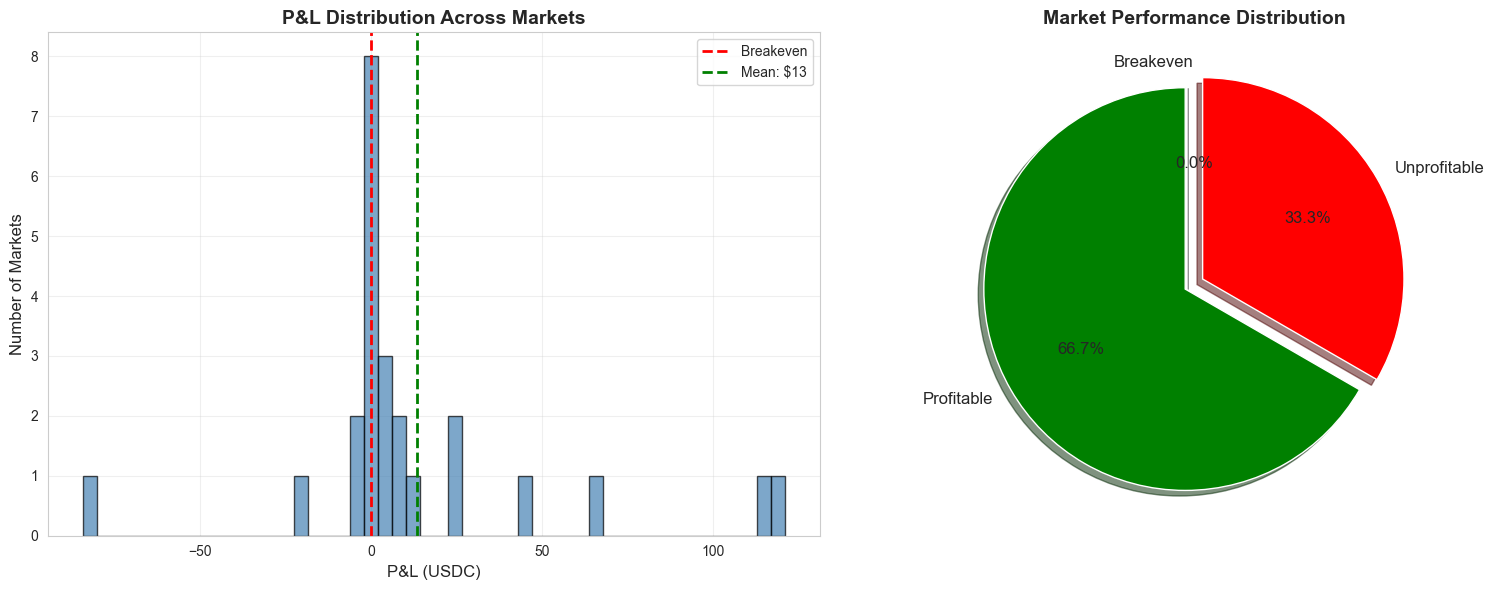

In [76]:
# P&L Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
axes[0].hist(market_pnl['pnl'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Breakeven')
axes[0].axvline(x=market_pnl['pnl'].mean(), color='green', linestyle='--', linewidth=2, label=f"Mean: ${market_pnl['pnl'].mean():,.0f}")
axes[0].set_xlabel('P&L (USDC)', fontsize=12)
axes[0].set_ylabel('Number of Markets', fontsize=12)
axes[0].set_title('P&L Distribution Across Markets', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Pie chart of profitable vs unprofitable
sizes = [positive_markets, negative_markets, neutral_markets]
labels_pie = ['Profitable', 'Unprofitable', 'Breakeven']
colors_pie = ['green', 'red', 'gray']
explode = (0.05, 0.05, 0)

axes[1].pie(sizes, explode=explode, labels=labels_pie, colors=colors_pie, autopct='%1.1f%%',
            shadow=True, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Market Performance Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## Trade Details by Asset ID

In [79]:
def show_trades_for_asset(asset_id: str):
    """
    Display all trades for a specific asset ID.
    
    Args:
        asset_id: The asset to filter trades
    """
    # Filter trades for the specific asset
    asset_trades = df[df['asset'] == asset_id].copy()
    
    if len(asset_trades) == 0:
        print(f"⚠️ No trades found for asset ID: {asset_id}")
        return
    
    # Sort by timestamp
    asset_trades = asset_trades.sort_values('datetime')
    
    # Get market info
    market_info = asset_trades.iloc[0]
    
    print("📊 TRADE DETAILS FOR ASSET")
    print("=" * 100)
    print(f"\nMarket: {market_info['title']}")
    print(f"Outcome: {market_info['outcome']}")
    print(f"Asset ID: {asset_id}")
    print(f"\nTotal Trades: {len(asset_trades)}")
    print(f"Total Volume: ${asset_trades['usdcSize'].sum():,.2f}")
    print(f"Net Cash Flow: ${asset_trades['cash_flow'].sum():,.2f}")
    print("\n" + "=" * 100)
    
    # Display each trade
    for idx, trade in asset_trades.iterrows():
        print(f"\n{trade['datetime'].strftime('%Y-%m-%d %H:%M:%S')} | {trade['side']:4s} | "
              f"Size: {trade['size']:8.2f} @ ${trade['price']:.3f} | "
              f"USDC: ${trade['usdcSize']:8.2f} | "
              f"Cash Flow: ${trade['cash_flow']:+8.2f}")
        print(f"   Tx: {trade['transactionHash']}")
    
    print("\n" + "=" * 100)
    print(f"Summary: {len(asset_trades)} trades | Volume: ${asset_trades['usdcSize'].sum():,.2f} | "
          f"P&L: ${asset_trades['cash_flow'].sum():+,.2f}")
    
    return asset_trades


# Example usage - paste an asset ID from the profitable/unprofitable markets above:
ASSET_ID = "80704965075011098851649145472612346439987472535253757475270587766261451418770"
show_trades_for_asset(ASSET_ID)

📊 TRADE DETAILS FOR ASSET

Market: Will Exxon Mobil (XOM) beat quarterly earnings?
Outcome: No
Asset ID: 80704965075011098851649145472612346439987472535253757475270587766261451418770

Total Trades: 1
Total Volume: $4.69
Net Cash Flow: $-4.69


2025-10-27 21:12:45 | BUY  | Size:    19.70 @ $0.238 | USDC: $    4.69 | Cash Flow: $   -4.69
   Tx: 0xcbf3c0a88cb25411e7afed05260e4d08ba55a43c9c914e18bf123e91063861e1

Summary: 1 trades | Volume: $4.69 | P&L: $-4.69


,proxyWallet,timestamp,conditionId,type,size,usdcSize,transactionHash,price,asset,side,...,icon,eventSlug,outcome,name,pseudonym,bio,profileImage,profileImageOptimized,datetime,cash_flow
0,0xc3da2b26f845d799b9d456828753f5a3af57d974,1761599565,0x8b7ffa2267c76412d7eff4b0382e8ad411ec128ad6d0...,TRADE,19.7,4.6886,0xcbf3c0a88cb25411e7afed05260e4d08ba55a43c9c91...,0.238,8070496507501109885164914547261234643998747253...,BUY,...,https://polymarket-upload.s3.us-east-2.amazona...,xom-quarterly-earnings-nongaap-eps-2025-10-31-...,No,alcaudi,Meaty-Prevalence,,,,2025-10-27 21:12:45,-4.6886
